In [1]:
import time

import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns

In [2]:
def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [3]:
train_images = np.load("Kannada_MNIST_npz/Kannada_MNIST/X_kannada_MNIST_train.npz")['arr_0']
test_images = np.load("Kannada_MNIST_npz/Kannada_MNIST/X_kannada_MNIST_test.npz")['arr_0']
train_labels = np.load("Kannada_MNIST_npz/Kannada_MNIST/y_kannada_MNIST_train.npz")['arr_0']
test_labels = np.load("Kannada_MNIST_npz/Kannada_MNIST/y_kannada_MNIST_test.npz")['arr_0']
digi_images = np.load("Kannada_MNIST_npz/Dig_MNIST/X_dig_MNIST.npz")['arr_0']
digi_labels = np.load("Kannada_MNIST_npz/Dig_MNIST/y_dig_MNIST.npz")['arr_0']

In [4]:
from sklearn.model_selection import train_test_split
train_digi_x, test_digi_x, train_digi_y, test_digi_y = train_test_split(digi_images, digi_labels, 
                                                                        test_size=0.9,stratify=digi_labels, 
                                                                        random_state=71)


In [5]:
train_digi_x.shape

(1024, 28, 28)

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
train_x = np.concatenate((train_images, train_digi_x), axis=0)
train_y = np.concatenate((train_labels, train_digi_y), axis=0)

In [8]:
train_x.shape

(61024, 28, 28)

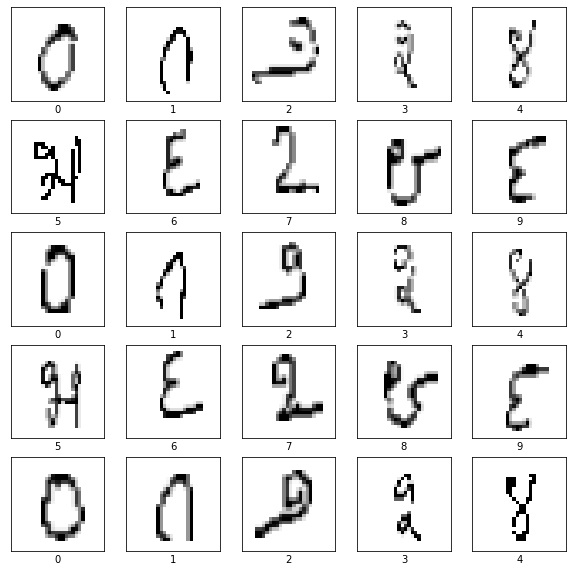

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

In [10]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [11]:
img_rows, img_cols = 28, 28
batch_size = 128
num_classes = 10
epochs = 10

In [12]:
x_train = np.expand_dims(train_x, axis=-1)
x_test = np.expand_dims(test_images, axis=-1)
y_train = keras.utils.to_categorical(train_y)
y_test = keras.utils.to_categorical(test_labels)

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.01,
                                                      random_state=71, stratify = y_train)

In [14]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

Using TensorFlow backend.


In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          #callbacks=[mcp_save],
          validation_data=(x_valid, y_valid))

Train on 60413 samples, validate on 611 samples
Epoch 1/10
60413/60413 [==============================] - 23s 375us/sample - loss: 2.1504 - acc: 0.3972 - val_loss: 0.5138 - val_acc: 0.9264
Epoch 2/10
60413/60413 [==============================] - 23s 378us/sample - loss: 0.6773 - acc: 0.8068 - val_loss: 0.1854 - val_acc: 0.9738
Epoch 3/10
60413/60413 [==============================] - 25s 417us/sample - loss: 0.3369 - acc: 0.9183 - val_loss: 0.1132 - val_acc: 0.9820
Epoch 4/10
60413/60413 [==============================] - 26s 430us/sample - loss: 0.2158 - acc: 0.9525 - val_loss: 0.0976 - val_acc: 0.9820
Epoch 5/10
60413/60413 [==============================] - 49s 805us/sample - loss: 0.1554 - acc: 0.9665 - val_loss: 0.0671 - val_acc: 0.9869
Epoch 6/10
60413/60413 [==============================] - 71s 1ms/sample - loss: 0.1159 - acc: 0.9757 - val_loss: 0.0808 - val_acc: 0.9885
Epoch 7/10
60413/60413 [==============================] - 80s 1ms/sample - loss: 0.1030 - acc: 0.9777 - val_

In [17]:
#loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Xtest loss:', loss)
print('Xtest accuracy:', accuracy)
#print('Xtest f1:', f1_score)
#print('Xtest precision:', precision)
#print('Xtest recall:', recall)

Xtest loss: 0.2396828329101205
Xtest accuracy: 0.9597


In [18]:
test_digi_x = np.expand_dims(test_digi_x, axis=-1)
test_digi_y = keras.utils.to_categorical(test_digi_y)

In [19]:
#loss, accuracy, f1_score, precision, recall = model.evaluate(x_digi_test, y_digi_test, verbose=0)
loss, accuracy = model.evaluate(test_digi_x, test_digi_y, verbose=0)
print('Xtest loss:', loss)
print('Xtest accuracy:', accuracy)
#print('Xtest f1:', f1_score)
#print('Xtest precision:', precision)
#print('Xtest recall:', recall)

Xtest loss: 1.1287087091348238
Xtest accuracy: 0.8562283


In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(x_test, batch_size=32, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), predicted, digits = 4)
confusion_matrix = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=predicted)
print(report)
print(confusion_matrix)

10000/10000 [==============================] - 8s 766us/sample
              precision    recall  f1-score   support

           0     0.9886    0.8690    0.9250      1000
           1     0.8800    0.9900    0.9318      1000
           2     0.9990    0.9980    0.9985      1000
           3     0.9601    0.9630    0.9616      1000
           4     0.9243    0.9890    0.9556      1000
           5     0.9872    0.9290    0.9572      1000
           6     0.9338    0.9740    0.9535      1000
           7     0.9859    0.9070    0.9448      1000
           8     0.9871    0.9930    0.9900      1000
           9     0.9714    0.9850    0.9782      1000

    accuracy                         0.9597     10000
   macro avg     0.9617    0.9597    0.9596     10000
weighted avg     0.9617    0.9597    0.9596     10000

[[869 116   0   6   5   0   0   0   2   2]
 [  0 990   0   5   1   1   0   2   1   0]
 [  1   1 998   0   0   0   0   0   0   0]
 [  0  11   1 963   3   5   5  11   0   1]
 [  0 

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_digi_x, batch_size=32, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(test_digi_y, axis=1), predicted, digits = 4)
confusion_matrix = confusion_matrix(y_true=np.argmax(test_digi_y, axis=1), y_pred=np.argmax(pred, axis=1))
print(report)
print(confusion_matrix)

9216/9216 [==============================] - 2s 248us/sample
              precision    recall  f1-score   support

           0     0.9542    0.6779    0.7926       922
           1     0.8322    0.9089    0.8688       922
           2     0.8909    0.9295    0.9098       922
           3     0.7874    0.8447    0.8151       921
           4     0.9421    0.8827    0.9114       921
           5     0.8281    0.9674    0.8923       921
           6     0.7244    0.8132    0.7662       921
           7     0.8975    0.7408    0.8116       922
           8     0.8774    0.9241    0.9002       922
           9     0.8954    0.8731    0.8841       922

    accuracy                         0.8562      9216
   macro avg     0.8630    0.8562    0.8552      9216
weighted avg     0.8630    0.8562    0.8552      9216

[[625 135  19  49   0  11   7   0  34  42]
 [ 12 838   7  23   1  29   0   2   7   3]
 [ 10   8 857  23   0   8  10   2   3   1]
 [  3   1  24 778   1  73  15  22   4   0]
 [  1   

In [22]:
#plot_cm(np.argmax(y_digi_test, axis=1), np.argmax(pred, axis=1))

In [23]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              37752832  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0

In [24]:
from sklearn.metrics import confusion_matrix

pred = model.predict(x_test, batch_size=32, verbose=1)
predicted = np.argmax(pred, axis=1)
confusion_matrix = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=predicted)

10000/10000 [==============================] - 7s 738us/sample


In [25]:
print(confusion_matrix)

[[869 116   0   6   5   0   0   0   2   2]
 [  0 990   0   5   1   1   0   2   1   0]
 [  1   1 998   0   0   0   0   0   0   0]
 [  0  11   1 963   3   5   5  11   0   1]
 [  0   0   0   4 989   4   2   0   0   1]
 [  0   1   0   6  61 929   3   0   0   0]
 [  0   3   0   0   4   0 974   0   1  18]
 [  6   2   0  17   5   1  56 907   2   4]
 [  0   0   0   2   1   1   0   0 993   3]
 [  3   1   0   0   1   0   3   0   7 985]]


In [26]:
print(np.argmax(y_test, axis=1))

[0 1 2 ... 7 8 9]
